Using xgboost or a random forest regressor to determine relevant features

In [52]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

In [53]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

In [54]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'

In [55]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [56]:
import numpy as np

def get_signals(price_volume_df):
    coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals["price-1"] = price_volume_df["close"].shift()
    coin_signals["price-2"] = price_volume_df["close"].shift(2)
    coin_signals["log price-1"] = np.log(coin_signals["price-1"])
    coin_signals["log price-2"] = np.log(coin_signals["price-2"])
    coin_signals["price-1 - price-2"] = coin_signals["price-1"] - coin_signals["price-2"]
    coin_signals["price change rate"] = coin_signals["price-1"] / coin_signals["price-2"] - 1
    coin_signals["log price quotient"] = np.log(coin_signals["price-1"] / coin_signals["price-2"])

    coin_signals["volume-1"] = price_volume_df["volume"].shift()
    coin_signals.loc[coin_signals["volume-1"] == 0,"volume-1"] = 0.001
    coin_signals["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals.loc[coin_signals["volume-2"] == 0,"volume-2"] = 0.001
    coin_signals["log volume-1"] = np.log(coin_signals["volume-1"])
    #coin_signals["log volume-1"][coin_signals["log volume-1"] == float('-inf')] = 0.001
    coin_signals["log volume-2"] = np.log(coin_signals["volume-2"])
    #coin_signals["log volume-2"][coin_signals["log volume-2"] == float('-inf')] = 0.001
    coin_signals["volume-1 - volume-2"] = coin_signals["volume-1"] - coin_signals["volume-2"]
    coin_signals["volume change rate"] = coin_signals["volume-1"] / coin_signals["volume-2"] - 1
    coin_signals["log volume quotient"] = np.log(coin_signals["volume-1"] / coin_signals["volume-2"])
    #coin_signals["log volume quotient"][coin_signals["log volume quotient"] == float('-inf')] = -10.0

    price_columns = [
        "price-1", "price-2", "log price-1", "log price-2", "price-1 - price-2", "price change rate",
        "log price quotient"]

    volume_columns = [
        "volume-1", "volume-2", "log volume-1", "log volume-2", "volume-1 - volume-2", "volume change rate",
        "log volume quotient"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals[p_col + " x " + v_col] = coin_signals[p_col] * coin_signals[v_col]
    
    return coin_signals


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        price_volume_df = px_data[coin][["close", "volume"]].astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals

In [57]:
px_data['BTCUSDT']['close']

open_time
2020-01-01 00:00:00     7230.71000000
2020-01-01 04:00:00     7205.50000000
2020-01-01 08:00:00     7195.80000000
2020-01-01 12:00:00     7233.02000000
2020-01-01 16:00:00     7223.72000000
                            ...      
2025-03-07 20:00:00    86791.40000000
2025-03-08 00:00:00    86021.48000000
2025-03-08 04:00:00    86221.43000000
2025-03-08 08:00:00    85986.20000000
2025-03-08 12:00:00    86288.98000000
Name: close, Length: 11356, dtype: object

In [58]:
m = len(px_data['BTCUSDT'].index)
px_data['BTCUSDT'].index[int(m * 0.5)]


Timestamp('2022-08-05 04:00:00')

In [59]:
from sklearn.ensemble import RandomForestRegressor

in_sample_end_datetime = pd.to_datetime('2022-08-05 04:00:00')

coin_to_signals = get_signals_for_all_coins(px_data)
coin_to_rfr_model = dict()

for coin, signals in coin_to_signals.items():
    rfr_model = RandomForestRegressor(random_state=836)
    
    in_sample_signals = signals.iloc[2:].loc[:in_sample_end_datetime]
    in_sample_close_price = px_data[coin]['close'].iloc[2:].loc[:in_sample_end_datetime]
    
    rfr_model.fit(in_sample_signals, in_sample_close_price)
    coin_to_rfr_model[coin] = rfr_model
    print(f"Model fitted for {coin}.")

Model fitted for BTCUSDT.
Model fitted for ETHUSDT.
Model fitted for ADAUSDT.
Model fitted for BNBUSDT.
Model fitted for XRPUSDT.
Model fitted for DOTUSDT.
Model fitted for MATICUSDT.


In [60]:
coin_to_signals['BNBUSDT'].columns[coin_to_signals['BNBUSDT'].iloc[2:].isna().any()]

Index([], dtype='object')

In [61]:
coin_to_signals['BNBUSDT'].iloc[2:][coin_to_signals['BNBUSDT'].iloc[2:]['price-1 - price-2 x log volume-1'].isna()]

,price-1,price-2,log price-1,log price-2,price-1 - price-2,price change rate,log price quotient,volume-1,volume-2,log volume-1,...,price change rate x volume-1 - volume-2,price change rate x volume change rate,price change rate x log volume quotient,log price quotient x volume-1,log price quotient x volume-2,log price quotient x log volume-1,log price quotient x log volume-2,log price quotient x volume-1 - volume-2,log price quotient x volume change rate,log price quotient x log volume quotient
open_time,,,,,,,,,,,,,,,,,,,,,


In [62]:
coin_to_signals['BNBUSDT']["log volume quotient"][coin_to_signals['BNBUSDT']["log volume quotient"] != float('-inf')].min()

-13.470961793823383

In [63]:
coin_to_signals['BNBUSDT']["volume-1"][coin_to_signals['BNBUSDT']["volume-1"] != 0.0].min()

0.001

In [65]:
coin_to_rfr_model['BTCUSDT']

RandomForestRegressor(random_state=836)

<Axes: xlabel='open_time'>

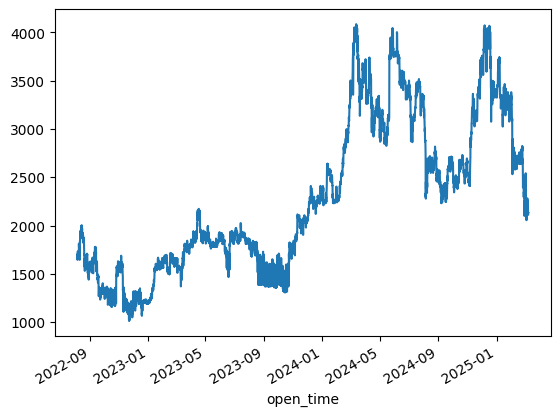

In [68]:
from datetime import timedelta

out_sample_start_datetime = in_sample_end_datetime + timedelta(hours=4)
eth_signals_out_sample = coin_to_signals['ETHUSDT'].loc[out_sample_start_datetime:]
eth_out_sample_predictions = coin_to_rfr_model['ETHUSDT'].predict(eth_signals_out_sample)
eth_out_sample_predictions = pd.Series(eth_out_sample_predictions, index=eth_signals_out_sample.index)

eth_out_sample_predictions.plot()

<Axes: xlabel='open_time'>

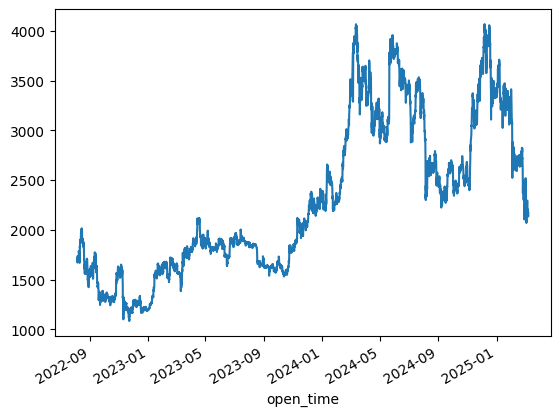

In [73]:
eth_price = px_data['ETHUSDT'].loc[out_sample_start_datetime:]['close'].astype(float)
eth_price.plot()

<Axes: xlabel='open_time'>

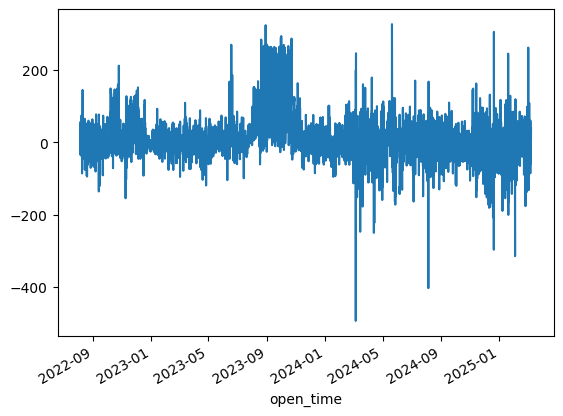

In [75]:
(eth_price - eth_out_sample_predictions).plot()

In [76]:
(eth_price - eth_out_sample_predictions).mean()

11.421993693852446

In [81]:
eth_residuals = eth_price - eth_out_sample_predictions
mean = eth_residuals.mean()
std = eth_residuals.std()

(eth_residuals - mean) / std

open_time
2022-08-05 08:00:00    0.696224
2022-08-05 12:00:00   -0.722754
2022-08-05 16:00:00    0.383382
2022-08-05 20:00:00    0.593472
2022-08-06 00:00:00   -0.052072
                         ...   
2025-03-07 20:00:00   -1.117669
2025-03-08 00:00:00    0.260325
2025-03-08 04:00:00   -0.184460
2025-03-08 08:00:00   -0.153981
2025-03-08 12:00:00    0.451937
Length: 5677, dtype: float64

In [ ]:
coin_to_z_scores = dict()

for coin, model in coin_to_rfr_model.items():
    signals_out_sample = coin_to_signals[coin].loc[out_sample_start_datetime:]
    out_sample_predictions = model.predict(signals_out_sample)
    out_sample_predictions = pd.Series(out_sample_predictions, index=signals_out_sample.index)
    out_sample_price = px_data[coin].loc[out_sample_start_datetime:]['close'].astype(float)
    
    residuals = out_sample_price - out_sample_predictions
    residuals_mean = residuals.mean()
    residuals_std = residuals.std()
    z_scores = (residuals - residuals_mean) / residuals_std
    
    coin_to_z_scores[coin] = z_scores

# eth_out_sample_predictions.plot()